In [1]:
import os
import cv2
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

get_session()

In [4]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

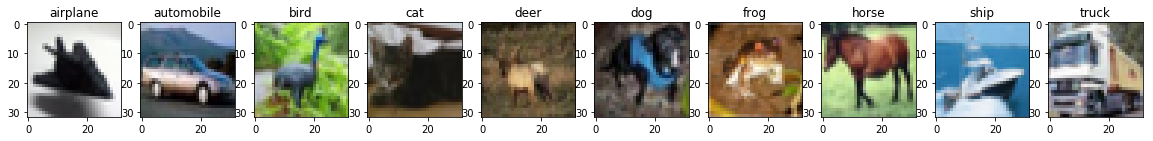

In [6]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])

plt.show()

In [7]:
model = keras.models.load_model('./cifar10.h5')

5 0.97384477
[5]


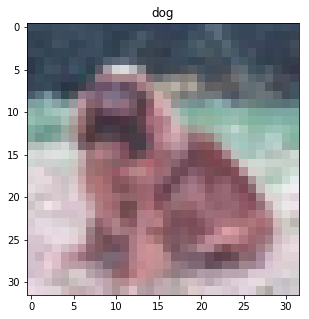

In [8]:
idx = 101
result_idx = model.predict_on_batch(x_test[idx][np.newaxis,...]/255).argmax()
print(result_idx, model.predict_on_batch(x_test[idx][np.newaxis,...]/255)[0,result_idx])
print(y_test[idx])

plt.figure(figsize=(5,5))
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx][0]])
plt.show()

# Selectivity

In [ ]:
def get_smoothgrad(img_input, saliency, n=10, sigma=1):
    result = np.zeros_like(img_input)
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    return result / n

In [ ]:
batch_size = 100
iteration = 100
sigma = 1
isplot = False

tot_score = {i: [] for i in range(10)}

In [ ]:
for label in range(10):
    print('***** label {} *****'.format(label))
    y_c = model.output[0, label]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    
    idx_coord = np.where(y_test == label)[0]
    X = np.zeros((batch_size, 32, 32, 3))
    for batch in range(batch_size):
        X[batch] = x_test[idx_coord[batch]]/255
        
    Y = np.array([[1 if label==i else 0 for i in range(10)] for _ in range(batch_size)])
    
    for batch in tqdm.trange(batch_size):
        x_input = X[batch].copy()
        y_input = Y[batch].copy()
        
        score_list = []
        if isplot:
            plt.figure(figsize=(30,30))
            
        for it in range(iteration):
            score = model.evaluate(x_input[np.newaxis,...], y_input[np.newaxis,...], verbose=0)[1]
            score_list.append(score)
            
            gradmap = np.abs(np.squeeze(get_smoothgrad(x_input[np.newaxis,...], saliency, sigma=sigma)))
            
            if isplot:
                plt.subplot(1,20,2*(it%10)+1)
                plt.imshow(np.squeeze(x_input))
                plt.subplot(1,20,2*(it%10)+2)
                plt.imshow(np.squeeze(gradmap))
                if it%10 == 9:
                    plt.show()
                    plt.figure(figsize=(30,30))
            
            coord = np.where(gradmap == gradmap.max())
            x_input[coord] = 0.
        
        tot_score[label].append(score_list)

***** label 0 *****


100%|██████████| 100/100 [11:06<00:00,  6.69s/it]


***** label 1 *****


 32%|███▏      | 32/100 [03:32<07:29,  6.62s/it]

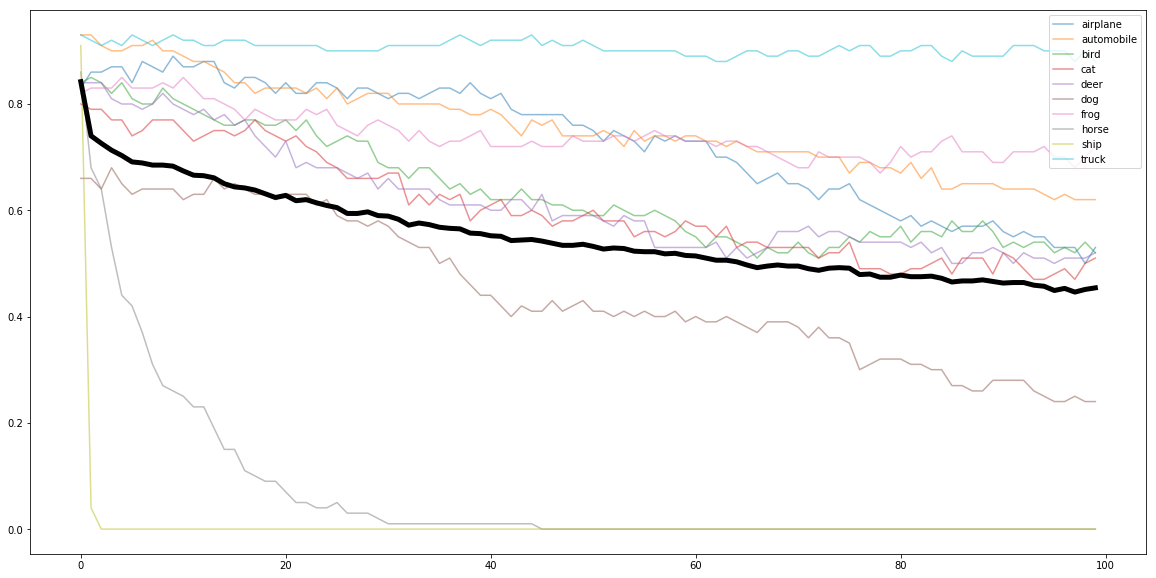

In [20]:
plt.figure(figsize=(20,10))
for i, k in enumerate(tot_score.keys()):
    plt.plot(np.array(tot_score[k]).mean(axis=0), alpha=.5, label=label_list[k])
    
    if i == 0:
        total = np.array(tot_score[k]).mean(axis=0)
    else:
        total += np.array(tot_score[k]).mean(axis=0)
        
total /= 10
plt.plot(total, color='black', linewidth=5)
plt.legend(loc=1)
# plt.xlim((0, 100))
# plt.ylim((0., 1.))
plt.show()

In [16]:
from sklearn.metrics import auc
AOC = auc(np.arange(0., 1., .01), 1-total)
print('AOC : {:.4f}'.format(AOC))

AOC : 0.4443
